## Function to include in earthaccess
Very scrapily written currently, but has all the important componenets:
1. Get CMR records and check if there is a link to a virtual data set reference file, in the requested format.
2. If it exists in the requested format, get the reference file from the DAAC.
3. Use the reference file to open and return the data set.

In [77]:
def open_cloudopt(short_name, daac="PODAAC", reffile_type='JSON'):
    """
    """
    import earthaccess
    import requests
    import fsspec
    import xarray as xr
    import zipfile
    
    ## Find collection-level metadata (UMM-C) on CMR:
    token_edl = earthaccess.get_edl_token()['access_token']
    ummc_search_url = "https://cmr.earthdata.nasa.gov/search/collections.umm_json?token={0}&ShortName={1}"
    ummc = requests.get(ummc_search_url.format(token_edl, short_name)).json()

    ## Look within UMM-C for links to virtual data set reference files:
    related_urls = ummc["items"][0]["umm"]["RelatedUrls"]
    url_descriptions = [e['Description'] for e in related_urls]
        # Currently it is assumed that link descriptions have the following format:
    vds_descript_fmt = "Virtual data set reference file for first decade of MUR record in {0} (experimental)"
    vds_descript = vds_descript_fmt.format(reffile_type)
    if vds_descript in url_descriptions:
        print("Virtual data set reference file exists in", reffile_type, "format.")
    else:
        print(
            "Virtual data set reference file does not exists in", reffile_type, "format.",
            "There may be a reference file in a different format, or else you will have to",
            "open this data set using traditional netCDF/HDF methods."
            )
        return

    ## If reference file exists, get it:
    if reffile_type=='JSON': # Can load directly into object.
        ref = requests.get(related_urls[url_descriptions.index(vds_descript)]['URL']).json()
    elif reffile_type=='PARQUET': # In this case, download and unzip first.
        url_parq = related_urls[url_descriptions.index(vds_descript)]['URL']
        r = requests.get(url_parq)
        fname_parqzip = url_parq.split("/")[-1]
        _ = open(fname_parqzip, 'wb').write(r.content)
        with zipfile.ZipFile(fname_parqzip, 'r') as zip_ref:
            zip_ref.extractall(".")


    ## Then use it to open and return the lazy-loaded data set:
    fs = earthaccess.get_s3_filesystem(daac=daac)
    def opendf_withref(ref, fs_data):
        """
        "ref" is a reference file or object. "fs_data" is a filesystem with credentials to
        access the actual data files. 
        """
        storage_opts = {"fo": ref, "remote_protocol": "s3", "remote_options": fs_data.storage_options}
        fs_ref = fsspec.filesystem('reference', **storage_opts)
        m = fs_ref.get_mapper('')
        data = xr.open_dataset(
            m, engine="zarr", chunks={},
            backend_kwargs={"consolidated": False}
            )
        return data

    if reffile_type=='JSON': # Can load directly into object.
        return opendf_withref(ref, fs)
    elif reffile_type=='PARQUET': # In this case, download and unzip first.
        return opendf_withref(".".join(fname_parqzip.split(".")[:-1]), fs)

## Testing the function
Starting here is what a user would do to check for and open the data

In [15]:
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [60]:
short_name = "MUR-JPL-L4-GLOB-v4.1"

In [66]:
%%time
data = open_cloudopt(short_name, reffile_type='JSON')

Virtual data set reference file exists in JSON format.
CPU times: user 18.9 s, sys: 3.29 s, total: 22.1 s
Wall time: 45.5 s


In [67]:
data

<xarray.Dataset> Size: 70TB
Dimensions:           (time: 3868, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 31kB 2002-06-01T09:00:00 ... 2013...
Data variables:
    analysed_sst      (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 10TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [ ]:
%%time

lat_slice=(-45,45)
lon_slice=(-10,10)
mean_regional = data["analysed_sst"].sel(time=data['time'][0], lat=slice(*lat_slice), lon=slice(*lon_slice)).mean().compute().item()
print(mean_regional)

CPU times: user 2.95 s, sys: 285 ms, total: 3.23 s
Wall time: 3.64 s


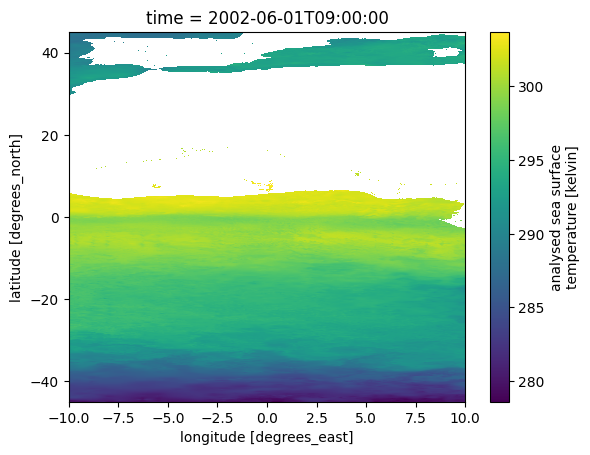

In [70]:
%%time

lat_slice=(-45,45)
lon_slice=(-10,10)
mean_regional = data["analysed_sst"].sel(time=data['time'][0], lat=slice(*lat_slice), lon=slice(*lon_slice)).plot()

#### PARQUET format

In [80]:
%%time
data_parq = open_cloudopt(short_name, reffile_type='PARQUET')

Virtual data set reference file exists in PARQUET format.
CPU times: user 69.8 ms, sys: 84.4 ms, total: 154 ms
Wall time: 1.92 s


In [81]:
data_parq

<xarray.Dataset> Size: 70TB
Dimensions:           (time: 3868, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time              (time) datetime64[ns] 31kB 2002-06-01T09:00:00 ... 2013...
Data variables:
    analysed_sst      (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 10TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 20TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20020601T210000Z
    time_coverage_start:        20020531T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [73]:
%%time

lat_slice=(-45,45)
lon_slice=(-10,10)
mean_regional = data_parq["analysed_sst"].sel(time=data_parq['time'][0], lat=slice(*lat_slice), lon=slice(*lon_slice)).mean().compute().item()
print(mean_regional)

294.10145213104306
CPU times: user 1.47 s, sys: 82.7 ms, total: 1.56 s
Wall time: 1.67 s


CPU times: user 2.91 s, sys: 336 ms, total: 3.25 s
Wall time: 3.06 s


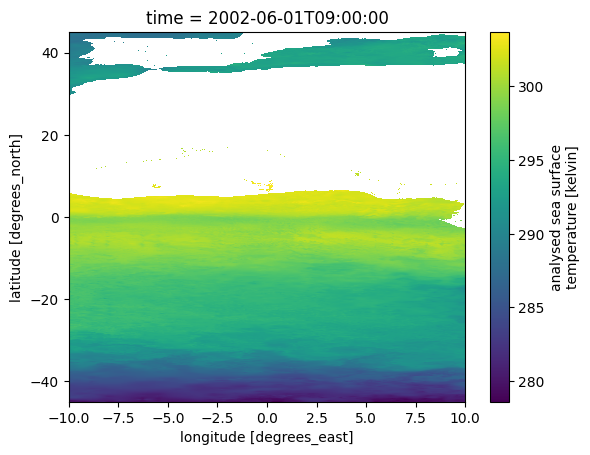

In [74]:
%%time

lat_slice=(-45,45)
lon_slice=(-10,10)
mean_regional = data_parq["analysed_sst"].sel(time=data_parq['time'][0], lat=slice(*lat_slice), lon=slice(*lon_slice)).plot()

#### Testing what happens if we ask for a collection that doesn't have a reference file currently

In [79]:
data_noref = open_cloudopt("COWVR_STPH8_L2_EDR_V10.0")

Virtual data set reference file does not exists in JSON format. There may be a reference file in a different format, or else you will have to open this data set using traditional netCDF/HDF methods.
